In [1]:
%pip install -qU "airavata-python-sdk[notebook]"
import airavata_jupyter_magic

%authenticate
%request_runtime hpc_gpu --file=cybershuttle.yml --walltime=60 --use=NeuroData25VC2:cloud
%wait_for_runtime hpc_gpu --live
%switch_runtime hpc_gpu

Note: you may need to restart the kernel to use updated packages.

Loaded airavata_jupyter_magic (2.1.4.post4) 
(current runtime = local)

  %authenticate                              -- Authenticate to access high-performance runtimes.
  %request_runtime <rt> [args]               -- Request a runtime named <rt> with configuration <args>.
                                                Call multiple times to request multiple runtimes.
  %restart_runtime <rt>                      -- Restart runtime <rt> if it hangs. This will clear all variables.
  %stop_runtime <rt>                         -- Stop runtime <rt> when no longer needed.
  %wait_for_runtime <rt>                     -- Wait for runtime <rt> to be ready.
  %switch_runtime <rt>                       -- Switch the active runtime to <rt>. All subsequent cells will run here.
  %%run_on <rt>                              -- Force a cell to always execute on <rt>, regardless of the active runtime.
  %stat_runtime <rt>               

Output()

Authenticated.

Requesting runtime=hpc_gpu...
[NeuroData25VC2:cloud, 60 Minutes, 1 Node(s), 4 CPU(s), 0 GPU(s), 4096 MB RAM, 1024 MB VRAM]
* modules=[]
* libraries=['python=3.10', 'pip', 'numpy', 'pytorch::pytorch', 'einops', 'matplotlib', 'scipy', 'scikit-learn', 'pytorch-lightning']
* pip=[]
* mounts=['neuroaihub-netformer:/cybershuttle_data/neuroaihub-netformer']
Requested runtime=hpc_gpu
Request successful: runtime=hpc_gpu


Output()

local:/var/folders/_n/fcf6nx4j67gbbt4_8mjqxdc80000gn/T/connection_62y8qzlr.json --> hpc_gpu:connection_62y8qzlr.json... [200]
started proc_name=hpc_gpu_kernel on rt=hpc_gpu. pid=3947
forwarding ports=[17935, 17936, 17937, 17938, 17939]
hpc_gpu:17935 -> access via 18.118.140.230:10000
hpc_gpu:17936 -> access via 18.118.140.230:10001
hpc_gpu:17937 -> access via 18.118.140.230:10002
hpc_gpu:17938 -> access via 18.118.140.230:10003
hpc_gpu:17939 -> access via 18.118.140.230:10004
started ipykernel tunnels for hpc_gpu at 18.118.140.230
started ipykernel client for hpc_gpu
Remote Jupyter kernel launched and connected for runtime=hpc_gpu.
Switched to runtime=hpc_gpu.


In [2]:
import os
 
for key in list(os.environ):
    if key.startswith("SLURM"):
        del os.environ[key]

executing cell on hpc_gpu...
waiting for cell to finish on hpc_gpu...
cell finished on hpc_gpu.


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import einops
from torch import nn, einsum
import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import pytorch_lightning as pl
from scipy import stats
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA

executing cell on hpc_gpu...
waiting for cell to finish on hpc_gpu...
cell finished on hpc_gpu.


In [4]:
plt.rcParams.update({
    'axes.titlesize': 14,
    'axes.labelsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'font.size': 14
})

executing cell on hpc_gpu...
waiting for cell to finish on hpc_gpu...
cell finished on hpc_gpu.


### Ground-Truth Cell Type-Level Connectivity from Patch Clamp Experiments (Campagnola et.al 2022)

Experimented cell types: EC, Pvalb, Sst, Vip

executing cell on hpc_gpu...
waiting for cell to finish on hpc_gpu...


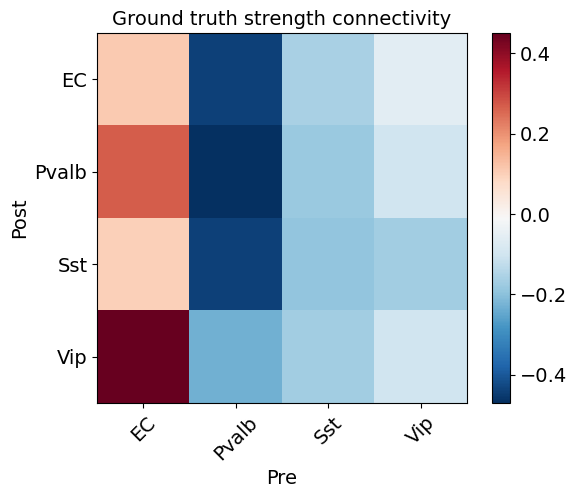

cell finished on hpc_gpu.


In [5]:
eval_cell_type_order = ['EC', 'Pvalb', 'Sst', 'Vip']
GT_strength_connectivity = np.zeros((len(eval_cell_type_order), len(eval_cell_type_order)))
GT_strength_connectivity[:] = np.nan

GT_strength_connectivity[eval_cell_type_order.index('EC')][eval_cell_type_order.index('EC')] = 0.11
GT_strength_connectivity[eval_cell_type_order.index('Pvalb')][eval_cell_type_order.index('EC')] = 0.27
GT_strength_connectivity[eval_cell_type_order.index('Sst')][eval_cell_type_order.index('EC')]= 0.1
GT_strength_connectivity[eval_cell_type_order.index('Vip')][eval_cell_type_order.index('EC')] = 0.45

GT_strength_connectivity[eval_cell_type_order.index('EC')][eval_cell_type_order.index('Pvalb')] = -0.44
GT_strength_connectivity[eval_cell_type_order.index('Pvalb')][eval_cell_type_order.index('Pvalb')] = -0.47
GT_strength_connectivity[eval_cell_type_order.index('Sst')][eval_cell_type_order.index('Pvalb')] = -0.44
GT_strength_connectivity[eval_cell_type_order.index('Vip')][eval_cell_type_order.index('Pvalb')] = -0.23

GT_strength_connectivity[eval_cell_type_order.index('EC')][eval_cell_type_order.index('Sst')] = -0.16
GT_strength_connectivity[eval_cell_type_order.index('Pvalb')][eval_cell_type_order.index('Sst')] = -0.18
GT_strength_connectivity[eval_cell_type_order.index('Sst')][eval_cell_type_order.index('Sst')] = -0.19
GT_strength_connectivity[eval_cell_type_order.index('Vip')][eval_cell_type_order.index('Sst')] = -0.17

GT_strength_connectivity[eval_cell_type_order.index('EC')][eval_cell_type_order.index('Vip')] = -0.06
GT_strength_connectivity[eval_cell_type_order.index('Pvalb')][eval_cell_type_order.index('Vip')] = -0.10
GT_strength_connectivity[eval_cell_type_order.index('Sst')][eval_cell_type_order.index('Vip')] = -0.17
GT_strength_connectivity[eval_cell_type_order.index('Vip')][eval_cell_type_order.index('Vip')] = -0.10

max_abs = np.max(np.abs(GT_strength_connectivity))
vmin_KK = -max_abs
vmax_KK = max_abs

plt.imshow(GT_strength_connectivity, cmap='RdBu_r', interpolation="nearest")
plt.colorbar()
plt.xlabel("Pre")
plt.ylabel("Post")
plt.title("Ground truth strength connectivity")
plt.xticks(np.arange(len(eval_cell_type_order)), eval_cell_type_order, rotation=45)
plt.yticks(np.arange(len(eval_cell_type_order)), eval_cell_type_order)
plt.show()

# Data

## Data Preprocessing Functions

In [6]:
def load_mouse_data_session(directory, date_exp, input_setting):
    gene_count = np.load(directory + date_exp + 'neuron.gene_count.npy')
    UniqueID = np.load(directory + date_exp + 'neuron.UniqueID.npy')

    with open(directory + date_exp + 'neuron.ttype.txt') as f:
        neuron_ttypes_raw  = f.readlines()
    neuron_ttypes = []
    for neuron_ttype in neuron_ttypes_raw:
        neuron_ttypes.append(neuron_ttype.strip())

    frame_states = np.load(directory + date_exp + input_setting + 'frame.states.npy')
    frame_times = np.load(directory + date_exp + input_setting + 'frame.times.npy')
    frame_activity = np.load(directory + date_exp + input_setting + 'frame.neuralActivity.npy')

    activity_norm = frame_activity
    return np.transpose(activity_norm), frame_states, frame_times, UniqueID.reshape(-1), neuron_ttypes


def assign_unique_neuron_ids(all_sessions_original_UniqueID, num_neurons_per_session):
    """
    all_sessions_original_UniqueID: a concatenated list of the original UniqueID from all sessions

    Return:
    all_sessions_new_UniqueID: a list of sessions new UniqueID, each session is a 1D array of shape num_neurons
    """

    # first reassign ID starting from 0 to those non-NaN neurons
    # same IDs should be assigned to neurons that have the same original UniqueID
    non_nan_values = all_sessions_original_UniqueID[~np.isnan(all_sessions_original_UniqueID)]
    unique_non_nan_values = np.unique(non_nan_values)
    id_mapping = {unique_non_nan_values[i]: i for i in range(len(unique_non_nan_values))}

    new_ids = [id_mapping[non_nan_values[i]] for i in range(len(non_nan_values))]
    all_sessions_new_UniqueID = np.copy(all_sessions_original_UniqueID)
    all_sessions_new_UniqueID[~np.isnan(all_sessions_new_UniqueID)] = new_ids

    # assign new IDs to those NaN neurons
    num_unique_non_nan = unique_non_nan_values.shape[0]     # new IDs start from num_unqiue_non_nan
    num_nan = np.sum(np.isnan(all_sessions_original_UniqueID))           # new IDs end with num_non_nan + num_nan -1

    new_ids = np.arange(num_unique_non_nan, num_unique_non_nan + num_nan)
    all_sessions_new_UniqueID[np.isnan(all_sessions_new_UniqueID)] = new_ids

    # segment all_sessions_new_UniqueID into sessions
    all_sessions_new_UniqueID = np.split(all_sessions_new_UniqueID, np.cumsum(num_neurons_per_session)[:-1])

    num_unique_neurons = num_unique_non_nan + num_nan
    return all_sessions_new_UniqueID, num_unique_neurons    # all_sessions_new_UniqueID shape: (num_sessions, num_neurons_per_session)


def assign_unique_cell_type_ids(all_sessions_original_cell_type, num_neurons_per_session):
    """
    all_sessions_original_cell_type: a concatenated list of the original cell types from all sessions)

    Return:
    all_sessions_new_cell_type: a list of sessions new cell type, each session is a 1D array of shape num_neurons
    """

    unique_cell_types = list(set(all_sessions_original_cell_type))
    unique_cell_types.sort()
    
    # Assign IDs to cell types
    cell_type_order = [unique_cell_types[i] for i in range(len(unique_cell_types))]
    print('cell_type_order:', cell_type_order)   

    # Get new cell type IDs
    all_sessions_new_cell_type_id = np.zeros(len(all_sessions_original_cell_type)).astype(int)
    for i in range(len(all_sessions_original_cell_type)):
        all_sessions_new_cell_type_id[i] = cell_type_order.index(all_sessions_original_cell_type[i])

    # Segment all_sessions_new_cell_type_id into sessions
    all_sessions_new_cell_type_id = np.split(all_sessions_new_cell_type_id, np.cumsum(num_neurons_per_session)[:-1])

    return all_sessions_new_cell_type_id, cell_type_order     # shape: num_sessions x num_neurons_per_session


def sliding_windows(all_sessions_acitvity, all_sessions_new_UniqueID, all_sessions_new_cell_type_id, all_sessions_state, window_size):
    """
    all_sessions_acitvity: a list of sessions activity, each session is a 2D array of shape num_neurons x num_frames
    all_sessions_new_UniqueID: a list of sessions new UniqueID, each session is a 1D array of shape num_neurons
    all_sessions_new_cell_type_id: a list of sessions new cell type id, each session is a 1D array of shape num_neurons

    Return:
    - all_sessions_activity_windows:
        a list of sessions activity windows, each session is a 3D array of shape num_windows x num_neurons x window_size
    - all_sessions_new_UniqueID_windows:
        a list of sessions new UniqueID windows, each session is a 2D array of shape num_windows x num_neurons (each row should be the same)
    - all_sessions_new_cell_type_id_windows:
        a list of sessions new cell type id windows, each session is a 2D array of shape num_windows x num_neurons (each row should be the same)
    """

    all_sessions_activity_windows = []
    all_sessions_new_UniqueID_windows = []
    all_sessions_new_cell_type_id_windows = []
    all_sessions_state_windows = []

    for i in range(len(all_sessions_acitvity)):
        num_neurons = all_sessions_acitvity[i].shape[0]
        num_frames = all_sessions_acitvity[i].shape[1]
        num_windows = num_frames - window_size + 1

        # activity
        activity_windows = np.zeros((num_windows, num_neurons, window_size))
        for j in range(num_windows):
            activity_windows[j] = all_sessions_acitvity[i][:, j:j+window_size]
        all_sessions_activity_windows.append(activity_windows)

        # UniqueID
        UniqueID_windows = np.zeros((num_windows, num_neurons))
        for j in range(num_windows):
            UniqueID_windows[j] = all_sessions_new_UniqueID[i]
        all_sessions_new_UniqueID_windows.append(UniqueID_windows)

        # cell type id
        cell_type_id_windows = np.zeros((num_windows, num_neurons))
        for j in range(num_windows):
            cell_type_id_windows[j] = all_sessions_new_cell_type_id[i]
        all_sessions_new_cell_type_id_windows.append(cell_type_id_windows)

        # state
        state_windows = np.zeros((num_windows, window_size))
        for j in range(num_windows):
            state_windows[j] = all_sessions_state[i][j:j+window_size]
        all_sessions_state_windows.append(state_windows)

    return all_sessions_activity_windows, all_sessions_new_UniqueID_windows, all_sessions_new_cell_type_id_windows, all_sessions_state_windows


class Mouse_All_Sessions_Dataset(TensorDataset):
    def __init__(
        self, 
        all_sessions_activity_windows,  # list of 3d tensors, each tensor is a session (num_window x n x window_size)) 
        all_sessions_new_UniqueID_windows,  # list of 2d tensors, each tensor is a session (num_window x n)
        all_sessions_new_cell_type_id_windows, # list of 2d tensors, each tensor is a session (num_window x n)
        all_sessions_state_windows,  # list of 2d tensors, each tensor is a session (num_window x window_size)
        batch_size=3,                      # real batch size
    ):
        self.num_batch_per_session = [session.shape[0] // batch_size for session in all_sessions_activity_windows]

        self.all_batch = []
        self.all_batch_neuron_ids = []
        self.all_batch_cell_type_ids = []
        self.all_batch_states = []
        for i in range(len(self.num_batch_per_session)):      # for each session
            for j in range(self.num_batch_per_session[i]):      # for each batch
                self.all_batch.append(torch.Tensor(all_sessions_activity_windows[i][j*batch_size:(j+1)*batch_size]).float())
                self.all_batch_neuron_ids.append(torch.Tensor(all_sessions_new_UniqueID_windows[i][j*batch_size:(j+1)*batch_size]).int())
                self.all_batch_cell_type_ids.append(torch.Tensor(all_sessions_new_cell_type_id_windows[i][j*batch_size:(j+1)*batch_size]).int())
                self.all_batch_states.append(torch.Tensor(all_sessions_state_windows[i][j*batch_size:(j+1)*batch_size]).int())

    def __getitem__(self, index):
        return self.all_batch[index], self.all_batch_neuron_ids[index], self.all_batch_cell_type_ids[index], self.all_batch_states[index]

    def __len__(self):
        return len(self.all_batch)


def generate_mouse_all_sessions_data(
    directory: str,
    input_mouse: list,
    input_sessions: list,
    window_size = 200, 
    batch_size = 32,
    num_workers: int = 6, 
    split_ratio = 0.8,
):
    
    input_sessions_file_path = []
    for i in range(len(input_mouse)):
        for j in range(len(input_sessions[i])):
            input_sessions_file_path.append({'date_exp': input_mouse[i] + '/' + input_sessions[i][j] + '/', 'input_setting': 'Blank/01/'})
            print(input_mouse[i] + '/' + input_sessions[i][j])

    all_sessions_original_UniqueID = []
    all_sessions_original_cell_type = []

    all_sessions_acitvity_TRAIN = []   # first 80% of the time
    all_sessions_acitvity_VAL = []

    all_sessions_state_TRAIN = []
    all_sessions_state_VAL = []

    num_neurons_per_session = []
    sessions_2_original_cell_type = []
    all_sessions_activity_flatten = []

    for i in range(len(input_sessions_file_path)):
        date_exp = input_sessions_file_path[i]['date_exp']
        input_setting = input_sessions_file_path[i]['input_setting']
        activity, frame_states, frame_times, UniqueID, neuron_ttypes = load_mouse_data_session(
            directory, date_exp, input_setting
        )
        frame_states = frame_states.flatten()

        all_sessions_original_UniqueID.append(UniqueID)
        all_sessions_acitvity_TRAIN.append(activity[:, :int(activity.shape[1]*split_ratio)])
        all_sessions_acitvity_VAL.append(activity[:, int(activity.shape[1]*split_ratio):])
        all_sessions_state_TRAIN.append(frame_states[:int(activity.shape[1]*split_ratio)])
        all_sessions_state_VAL.append(frame_states[int(activity.shape[1]*split_ratio):])
        num_neurons_per_session.append(activity.shape[0])
        all_sessions_activity_flatten.append(activity.flatten())

        # Get the first level of cell types
        neuron_types_result = []
        for j in range(len(neuron_ttypes)):
            # split by "-"
            neuron_types_result.append(neuron_ttypes[j].split("-")[0])

        sessions_2_original_cell_type.append(neuron_types_result)
        all_sessions_original_cell_type.append(neuron_types_result)

    all_sessions_original_UniqueID = np.concatenate(all_sessions_original_UniqueID)
    all_sessions_original_cell_type = np.concatenate(all_sessions_original_cell_type)
    all_sessions_activity_flatten = np.concatenate(all_sessions_activity_flatten)
    mu = np.mean(all_sessions_activity_flatten)
    std = np.std(all_sessions_activity_flatten)

    # all_sessions normalization
    all_sessions_acitvity_TRAIN = [(session - mu) / std for session in all_sessions_acitvity_TRAIN]
    all_sessions_acitvity_VAL = [(session - mu) / std for session in all_sessions_acitvity_VAL]
    
    ##############################################
    # Construct new UniqueID and cell type id
    ##############################################

    all_sessions_new_UniqueID, num_unqiue_neurons = assign_unique_neuron_ids(all_sessions_original_UniqueID, num_neurons_per_session)
    all_sessions_new_cell_type_id, cell_type_order = assign_unique_cell_type_ids(all_sessions_original_cell_type, num_neurons_per_session)

    neuron_id_2_cell_type_id = np.zeros((num_unqiue_neurons,)).astype(int)
    for i in range(len(all_sessions_new_UniqueID)):
        neuron_id_2_cell_type_id[all_sessions_new_UniqueID[i].astype(int)] = all_sessions_new_cell_type_id[i]

    ##############################################
    # Construct windows
    ##############################################

    # For TRAIN
    all_sessions_activity_windows_TRAIN, all_sessions_new_UniqueID_windows_TRAIN, all_sessions_new_cell_type_id_window_TRAIN, all_sessions_state_windows_TRAIN = sliding_windows(
        all_sessions_acitvity_TRAIN, all_sessions_new_UniqueID, all_sessions_new_cell_type_id, all_sessions_state_TRAIN, window_size=window_size
    )
    # For VAL
    all_sessions_activity_windows_VAL, all_sessions_new_UniqueID_windows_VAL, all_sessions_new_cell_type_id_window_VAL, all_sessions_state_windows_VAL = sliding_windows(
        all_sessions_acitvity_VAL, all_sessions_new_UniqueID, all_sessions_new_cell_type_id, all_sessions_state_VAL, window_size=window_size
    )

    ##############################################
    # Construct dataloaders
    ##############################################

    train_dataset = Mouse_All_Sessions_Dataset(
        all_sessions_activity_windows_TRAIN, 
        all_sessions_new_UniqueID_windows_TRAIN, 
        all_sessions_new_cell_type_id_window_TRAIN, 
        all_sessions_state_windows_TRAIN,
        batch_size=batch_size,       
    )
    val_dataset = Mouse_All_Sessions_Dataset(
        all_sessions_activity_windows_VAL, 
        all_sessions_new_UniqueID_windows_VAL, 
        all_sessions_new_cell_type_id_window_VAL, 
        all_sessions_state_windows_VAL,
        batch_size=batch_size,       
    )

    num_batch_per_session_TRAIN = train_dataset.num_batch_per_session
    num_batch_per_session_VAL = val_dataset.num_batch_per_session

    train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=num_workers)    # 1 is not real batch_size
    val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=num_workers)        # 1 is not real batch_size

    return train_dataloader, val_dataloader, num_unqiue_neurons, cell_type_order, all_sessions_new_cell_type_id, num_batch_per_session_TRAIN, num_batch_per_session_VAL, sessions_2_original_cell_type, neuron_id_2_cell_type_id

executing cell on hpc_gpu...
waiting for cell to finish on hpc_gpu...
cell finished on hpc_gpu.


## Data Preprocessing

Preprocess calcium imaging data into sliding-windows with window-size 60.

Separate TRAIN and VAL data by time. There is no overlap between TRAIN and VAL data:
1. The first 80% timesteps is TRAIN
2. The last 20% timesteps is VAL

In [7]:
input_mouse = ['SB025']
input_sessions = [['2019-10-23']]

window_size = 60
batch_size = 32

train_dataloader, val_dataloader, num_unqiue_neurons, cell_type_order, all_sessions_new_cell_type_id, num_batch_per_session_TRAIN, num_batch_per_session_VAL, sessions_2_original_cell_type, neuron_id_2_cell_type_id = generate_mouse_all_sessions_data(
    directory = 'cybershuttle_data/neuroaihub-netformer/Bugeon/',
    input_mouse=input_mouse,
    input_sessions=input_sessions,
    window_size=window_size,
    batch_size=batch_size,
    num_workers=0
)

executing cell on hpc_gpu...
waiting for cell to finish on hpc_gpu...
SB025/2019-10-23
cell_type_order: [np.str_('EC'), np.str_('IN'), np.str_('Lamp5'), np.str_('Pvalb'), np.str_('Serpinf1'), np.str_('Sncg'), np.str_('Sst'), np.str_('Vip')]
cell finished on hpc_gpu.


In [8]:
print('num_unqiue_neurons:', num_unqiue_neurons)
print('cell_type_order:', cell_type_order)
print('num_batch_per_session_TRAIN:', num_batch_per_session_TRAIN)
print('num_batch_per_session_VAL:', num_batch_per_session_VAL)

executing cell on hpc_gpu...
waiting for cell to finish on hpc_gpu...
num_unqiue_neurons: 527
cell_type_order: [np.str_('EC'), np.str_('IN'), np.str_('Lamp5'), np.str_('Pvalb'), np.str_('Serpinf1'), np.str_('Sncg'), np.str_('Sst'), np.str_('Vip')]
num_batch_per_session_TRAIN: [96]
num_batch_per_session_VAL: [22]
cell finished on hpc_gpu.


### Behavioral states in current session

executing cell on hpc_gpu...
waiting for cell to finish on hpc_gpu...
Total time length:  3072


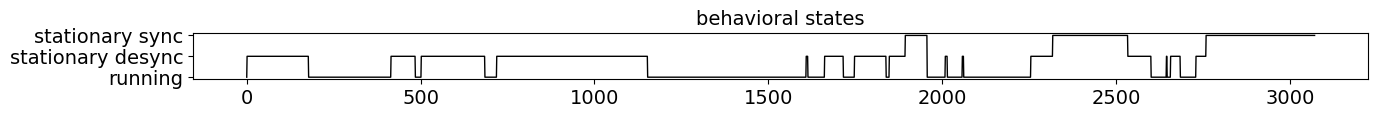

cell finished on hpc_gpu.


In [9]:
prediction_state_TRAIN = []
for idx, batch in enumerate(train_dataloader):
    x, neuron_ids, cell_type_ids, state = batch
    last_state = state[0, :, -1]
    prediction_state_TRAIN.append(last_state)

prediction_state_TRAIN = torch.cat(prediction_state_TRAIN, dim=0).cpu().numpy()
print('Total time length: ', len(prediction_state_TRAIN))

plt.figure(figsize=(14, 1.4))
plt.plot(prediction_state_TRAIN, 'black', label='inferred state 1', linewidth=1)
names = ['running', 'stationary desync', 'stationary sync']
plt.yticks([0, 1, 2], names)
plt.title('behavioral states')
plt.tight_layout()
plt.show()

### Get one batch from train_dataloader
Note: the first dimension is not the real batch size

In [10]:
for batch in train_dataloader:
    activity, neuron_ids, cell_type_ids, states = batch
    print('activity shape:', activity.shape)
    print('neuron_ids shape:', neuron_ids.shape)
    print('cell_type_ids shape:', cell_type_ids.shape)
    print('states shape:', states.shape)
    break

executing cell on hpc_gpu...
waiting for cell to finish on hpc_gpu...
activity shape: torch.Size([1, 32, 527, 60])
neuron_ids shape: torch.Size([1, 32, 527])
cell_type_ids shape: torch.Size([1, 32, 527])
states shape: torch.Size([1, 32, 60])
cell finished on hpc_gpu.


### Visualize one time-window in the batch

executing cell on hpc_gpu...
waiting for cell to finish on hpc_gpu...
neuron cell type: EC
states across current time-window:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1], dtype=torch.int32)


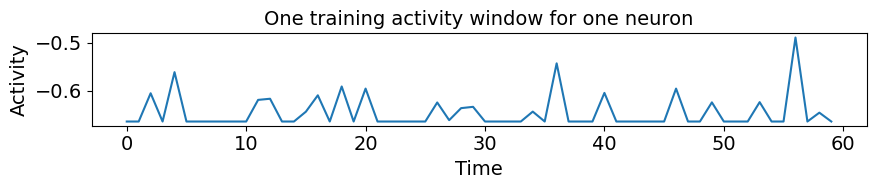

cell finished on hpc_gpu.


In [11]:
window_index = 5
neuron_index = 0
activity_window = activity[0, window_index, neuron_index]
activity_window = activity_window.cpu().numpy()
print('neuron cell type:', cell_type_order[cell_type_ids[0, window_index, neuron_index].item()])
print('states across current time-window: ', states[0, window_index])

plt.figure(figsize=(10, 1.2))
plt.plot(activity_window)
plt.title('One training activity window for one neuron')
plt.xlabel('Time')
plt.ylabel('Activity')
plt.show()

# Model

## Model Architecture

In [12]:
class Base(pl.LightningModule):
    def __init__(self,) -> None:
        super().__init__()
        self.save_hyperparameters()

    def forward(self, x):
        return NotImplementedError

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate, weight_decay=self.hparams.weight_decay)

        if self.hparams.scheduler == "plateau":
            lr_scheduler = {
                "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau(
                    optimizer,
                    patience=3,
                ),
                "monitor": "VAL_sum_loss",
            }
        elif self.hparams.scheduler == "cycle":
            lr_scheduler = {
                "scheduler": torch.optim.lr_scheduler.CyclicLR(
                    optimizer,
                    base_lr=self.hparams.learning_rate / 2,
                    max_lr=self.hparams.learning_rate * 2,
                    cycle_momentum=False,
                ),
                "interval": "step",
            }
        else:
            print("No scheduler is used")

        return [optimizer], [lr_scheduler]
    
    def training_step(self, batch, batch_idx):
        print("self.cell_type_level_constraint gradient: ", self.cell_type_level_constraint.grad)
        print("self.cell_type_level_constraint: ", self.cell_type_level_constraint)

        x, neuron_ids, cell_type_ids, state = batch
        print("unique num cell types: ", np.unique(cell_type_ids[0].clone().detach().cpu().numpy()))
        x = x.squeeze(0)                 # remove the fake batch_size
        neuron_ids = neuron_ids.squeeze(0)
        cell_type_ids = cell_type_ids.squeeze(0)

        # Make the last time step as the target
        target = x[:, :, -1*self.hparams.predict_window_size:].clone()
        pred, neuron_level_attention, cell_type_level_constraint = self(x[:, :, :-1*self.hparams.predict_window_size], neuron_ids)

        cell_type_ids_np = cell_type_ids[0].clone().detach().cpu().numpy()
        expanded_cell_type_level_constraint = torch.zeros((neuron_level_attention.shape[1],neuron_level_attention.shape[2]), requires_grad=True).to(pred.device)
        expanded_cell_type_level_var = torch.zeros((neuron_level_attention.shape[1],neuron_level_attention.shape[2]), requires_grad=True).to(pred.device)

        # Loop over unique cell types
        for i in list(np.unique(cell_type_ids_np)):
            # Find the neurons with the same cell type
            neuron_ids_with_same_cell_type_i = np.where(cell_type_ids_np == i)[0]
            for j in list(np.unique(cell_type_ids_np)):
                # Find the neurons with the same cell type
                neuron_ids_with_same_cell_type_j = np.where(cell_type_ids_np == j)[0]
                # Assign the same constraint to the neurons with the same cell type
                expanded_cell_type_level_constraint[neuron_ids_with_same_cell_type_i, neuron_ids_with_same_cell_type_j.reshape(-1,1)] = cell_type_level_constraint[i, j] * 1
                expanded_cell_type_level_constraint[neuron_ids_with_same_cell_type_j, neuron_ids_with_same_cell_type_i.reshape(-1,1)] = cell_type_level_constraint[j, i] * 1

                expanded_cell_type_level_var[neuron_ids_with_same_cell_type_i, neuron_ids_with_same_cell_type_j.reshape(-1,1)] = self.cell_type_level_var[i, j] ** 2
                expanded_cell_type_level_var[neuron_ids_with_same_cell_type_j, neuron_ids_with_same_cell_type_i.reshape(-1,1)] = self.cell_type_level_var[j, i] ** 2
    
        # Expand the first dimension of expanded_cell_type_level_constraint to batch_size
        expanded_cell_type_level_constraint = einops.repeat(expanded_cell_type_level_constraint, 'n d -> b n d', b=neuron_level_attention.shape[0])
        expanded_cell_type_level_var = einops.repeat(expanded_cell_type_level_var, 'n d -> b n d', b=neuron_level_attention.shape[0])
        
        # Use Gaussian NLL Loss to add constraint, var should be a hyperparameter
        constraint_loss = F.gaussian_nll_loss(neuron_level_attention, expanded_cell_type_level_constraint, reduction="mean", var=expanded_cell_type_level_var)
        
        target = target.reshape(pred.shape)

        if self.hparams.loss_function == "mse":
            if self.hparams.l1_on_causal_temporal_map != 0:
                loss = F.mse_loss(pred, target, reduction="mean") + self.hparams.l1_on_causal_temporal_map * sum([p.abs().sum() for p in self.attentionlayers[0][0].W_Q_W_KT.parameters()])
            else:
                loss = F.mse_loss(pred, target, reduction="mean")
        elif self.hparams.loss_function == "poisson":
            loss = F.poisson_nll_loss(pred, target, log_input=self.hparams.log_input, reduction="mean")
        elif self.hparams.loss_function == "gaussian":
            var = torch.ones(pred.shape, requires_grad=True).to(pred.device)
            loss = F.gaussian_nll_loss(pred, target, reduction="mean", var=var)

        self.log("TRAIN_constraint_loss", constraint_loss * self.hparams.constraint_loss_weight)
        self.log("TRAIN_" + str(self.hparams.loss_function) + "_loss", loss)
        self.log("TRAIN_sum_loss", loss + constraint_loss * self.hparams.constraint_loss_weight)
        return loss + constraint_loss * self.hparams.constraint_loss_weight
    
    def validation_step(self, batch, batch_idx):

        x, neuron_ids, cell_type_ids, state = batch
        x = x.squeeze(0)                 # remove the fake batch_size
        neuron_ids = neuron_ids.squeeze(0)
        cell_type_ids = cell_type_ids.squeeze(0)

        # Make the last time step as the target
        target = x[:, :, -1*self.hparams.predict_window_size:].clone()
        pred, neuron_level_attention, cell_type_level_constraint = self(x[:, :, :-1*self.hparams.predict_window_size], neuron_ids)

        cell_type_ids_np = cell_type_ids[0].clone().detach().cpu().numpy()
        expanded_cell_type_level_constraint = torch.zeros((neuron_level_attention.shape[1],neuron_level_attention.shape[2]), requires_grad=True).to(pred.device)
        expanded_cell_type_level_var = torch.zeros((neuron_level_attention.shape[1],neuron_level_attention.shape[2]), requires_grad=True).to(pred.device)
        
        # Loop over unique cell types
        for i in list(np.unique(cell_type_ids_np)):
            # Find the neurons with the same cell type
            neuron_ids_with_same_cell_type_i = np.where(cell_type_ids_np == i)[0]
            for j in list(np.unique(cell_type_ids_np)):
                # Find the neurons with the same cell type
                neuron_ids_with_same_cell_type_j = np.where(cell_type_ids_np == j)[0]
                # Assign the same constraint to the neurons with the same cell type
                expanded_cell_type_level_constraint[neuron_ids_with_same_cell_type_i, neuron_ids_with_same_cell_type_j.reshape(-1,1)] = cell_type_level_constraint[i, j]
                expanded_cell_type_level_constraint[neuron_ids_with_same_cell_type_j, neuron_ids_with_same_cell_type_i.reshape(-1,1)] = cell_type_level_constraint[j, i]

                expanded_cell_type_level_var[neuron_ids_with_same_cell_type_i, neuron_ids_with_same_cell_type_j.reshape(-1,1)] = self.cell_type_level_var[i, j] ** 2
                expanded_cell_type_level_var[neuron_ids_with_same_cell_type_j, neuron_ids_with_same_cell_type_i.reshape(-1,1)] = self.cell_type_level_var[j, i] ** 2

        expanded_cell_type_level_constraint = einops.repeat(expanded_cell_type_level_constraint, 'n d -> b n d', b=neuron_level_attention.shape[0])
        expanded_cell_type_level_var = einops.repeat(expanded_cell_type_level_var, 'n d -> b n d', b=neuron_level_attention.shape[0])

        constraint_loss = F.gaussian_nll_loss(neuron_level_attention, expanded_cell_type_level_constraint, reduction="mean", var=expanded_cell_type_level_var)
        
        if self.hparams.loss_function == "mse":
            loss = F.mse_loss(pred, target, reduction="mean")
        elif self.hparams.loss_function == "poisson":
            loss = F.poisson_nll_loss(pred, target, log_input=self.hparams.log_input, reduction="mean")
        elif self.hparams.loss_function == "gaussian":
            var = torch.ones(pred.shape, requires_grad=True).to(pred.device)
            loss = F.gaussian_nll_loss(pred, target, reduction="mean", var=var)

        self.log("VAL_constraint_loss", constraint_loss * self.hparams.constraint_loss_weight)
        self.log("VAL_" + str(self.hparams.loss_function) + "_loss", loss)
        self.log("VAL_sum_loss", loss + constraint_loss * self.hparams.constraint_loss_weight)
        return loss + constraint_loss * self.hparams.constraint_loss_weight
    
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, neuron_ids, cell_type_ids, state = batch
        x = x.squeeze(0)                 # remove the fake batch_size
        neuron_ids = neuron_ids.squeeze(0)
        cell_type_ids = cell_type_ids.squeeze(0)
        state = state.squeeze(0)

        # Make the last time step as the target
        target = x[:, :, -1*self.hparams.predict_window_size:].clone()
        pred, neuron_level_attention, cell_type_level_constraint = self(x[:, :, :-1*self.hparams.predict_window_size], neuron_ids)
        return pred, target, neuron_level_attention, state

executing cell on hpc_gpu...
waiting for cell to finish on hpc_gpu...
cell finished on hpc_gpu.


In [13]:
class Attention(nn.Module):
    def __init__(
        self,
        dim_X,
        dim_E,
        *,
        dropout=0.0,
        prediction_mode=False,
        activation='none', # 'sigmoid' or 'tanh' or 'softmax' or 'none'
    ):
        super().__init__()
        self.activation = activation

        self.scale = (dim_X + dim_E) ** -0.5

        # Q, K
        self.query_linear = nn.Linear(dim_X + dim_E, dim_X + dim_E, bias=False)
        self.key_linear = nn.Linear(dim_X + dim_E, dim_X + dim_E, bias=False)

        # dropouts
        self.attn_dropout = nn.Dropout(dropout)

        # prediction mode
        self.prediction_mode = prediction_mode

    def forward(self, x, e):

        x_e = torch.cat((x, e), dim=-1)

        batch_size, n, t = x.shape

        # Q, K
        queries = self.query_linear(x_e)
        keys = self.key_linear(x_e)

        logits = einsum("b n d, b m d -> b n m", queries, keys)
        if self.activation == 'softmax':
            attn = logits.softmax(dim=-1)
        elif self.activation == 'sigmoid':
            attn = F.sigmoid(logits)
        elif self.activation == 'tanh':
            attn = F.tanh(logits)
        elif self.activation == 'none':
            attn = logits

        attn = self.attn_dropout(attn)
        attn = attn * self.scale

        v = x  # identity mapping
        out = einsum("b n m, b m t -> b n t", attn, v)
        out = out + x   # Residual connection

        if self.prediction_mode == True:
            return out, attn
        else:
            return out

executing cell on hpc_gpu...
waiting for cell to finish on hpc_gpu...
cell finished on hpc_gpu.


In [14]:
class NetFormer(Base):
    def __init__(
        self,
        num_unqiue_neurons,
        num_cell_types,
        model_random_seed=42,
        window_size=200,
        predict_window_size=1,
        dropout=0.2,
        learning_rate=1e-4,
        scheduler="cycle",
        loss_function="mse", # "mse" or "poisson" or "gaussian"
        attention_activation="none", # "softmax" or "sigmoid" or "tanh"
        weight_decay=0,
        l1_on_causal_temporal_map=0,
        constraint_loss_weight=0,
        constraint_var=1,
        dim_E=30,
        layerNorm_x_e=True,
    ):
        super().__init__()
        self.save_hyperparameters()

        torch.manual_seed(model_random_seed)

        self.cell_type_level_constraint = nn.Parameter(torch.FloatTensor(num_cell_types, num_cell_types).uniform_(-1, 1))
        self.cell_type_level_var = nn.Parameter(torch.ones(num_cell_types, num_cell_types), requires_grad=True)

        self.predict_window_size = predict_window_size
        dim_X = window_size - predict_window_size

        # Attention

        self.embedding_table = nn.Embedding(
            num_embeddings=num_unqiue_neurons, embedding_dim=dim_E   # global unique neuron lookup table
        )

        self.layerNorm_x_e = layerNorm_x_e
        if layerNorm_x_e:
            self.layer_norm = nn.LayerNorm(dim_X+dim_E)
        else:
            self.layer_norm = nn.LayerNorm(dim_X)

        self.attentionlayers = nn.ModuleList()
        self.attentionlayers.append(
            nn.Sequential(
                Attention(
                    dim_X=dim_X,
                    dim_E=dim_E,
                    prediction_mode=True,
                    activation=attention_activation,
                ),
                nn.LayerNorm(dim_X),
            )
        )

    def forward(self, x, neuron_ids): # x: batch_size * (neuron_num*time), neuron_ids: batch_size * neuron_num
    
        e = self.embedding_table(neuron_ids[0])
        e = e.repeat(x.shape[0],1,1)  # (m, e) to (b, m, e)

        if self.layerNorm_x_e:
            x_e = self.layer_norm(torch.cat((x, e), dim=-1))
            # Split x and e
            x = x_e[:, :, :x.shape[-1]]
            e = x_e[:, :, x.shape[-1]:]
        else:
            x = self.layer_norm(x)

        attention_results = []
        x, attn = self.attentionlayers[0][0](x, e)
        attention_results.append(attn)

        x = self.attentionlayers[0][1](x)

        batch_neuron_num = attention_results[0].shape[-1]
        return x[:, :, -1*self.predict_window_size:], attention_results[0].view(-1, batch_neuron_num, batch_neuron_num), self.cell_type_level_constraint

executing cell on hpc_gpu...
waiting for cell to finish on hpc_gpu...
cell finished on hpc_gpu.


## Model Inference on Train Data for Sanity Check

executing cell on hpc_gpu...
waiting for cell to finish on hpc_gpu...


/home/exouser/cybershuttle/scratch/envs/befefb0d/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/exouser/cybershuttle/scratch/envs/befefb0d/lib ...
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/exouser/cybershuttle/scratch/envs/befefb0d/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True`

Predicting DataLoader 0: 100%|██████████| 96/96 [00:01<00:00, 64.24it/s]
(3072, 527, 1) (3072, 527, 1)


PREDICT Profiler Report

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                      	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                       	|  -              	|  1372           	|  1.6079         	

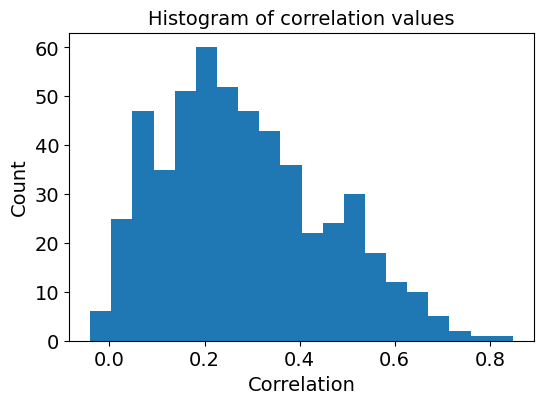

cell finished on hpc_gpu.


In [15]:
checkpoint_path = "cybershuttle_data/neuroaihub-netformer/model_checkpoint.ckpt"
trained_model = NetFormer.load_from_checkpoint(checkpoint_path)
trained_model.eval()

trainer = pl.Trainer(
    devices=[0],
    accelerator="gpu",
    benchmark=False,
    profiler="simple",
)

train_results = trainer.predict(trained_model, dataloaders=[train_dataloader])

predictions_TRAIN = []
ground_truths_TRAIN = []

index = 0
num_session = len(num_batch_per_session_TRAIN)
for i in range(num_session):
    predictions_TRAIN.append([])
    ground_truths_TRAIN.append([])

    for j in range(num_batch_per_session_TRAIN[i]):
        x_hat = train_results[index][0]
        x = train_results[index][1]
        
        predictions_TRAIN[i].append(x_hat)
        ground_truths_TRAIN[i].append(x)
        index += 1
    
    predictions_TRAIN[i] = torch.cat(predictions_TRAIN[i], dim=0).cpu().numpy()  # N * neuron_num * window_size
    ground_truths_TRAIN[i] = torch.cat(ground_truths_TRAIN[i], dim=0).cpu().numpy()  # N * neuron_num * window_size
    print(predictions_TRAIN[i].shape, ground_truths_TRAIN[i].shape)

prediction_state_TRAIN = []
for idx, batch in enumerate(train_dataloader):
    x, neuron_ids, cell_type_ids, state = batch
    last_state = state[0, :, -1]
    prediction_state_TRAIN.append(last_state)

prediction_state_TRAIN = torch.cat(prediction_state_TRAIN, dim=0).cpu().numpy()

T, N, W = predictions_TRAIN[0].shape
corr_per_neuron = []
for i in range(N):
    corr = np.corrcoef(ground_truths_TRAIN[0][:, i, 0].reshape(-1), predictions_TRAIN[0][:, i, 0].reshape(-1))[0, 1]
    corr_per_neuron.append(corr)

# plot histogram of correlation values
plt.figure(figsize=(6, 4))
plt.hist(corr_per_neuron, bins=20)
plt.xlabel('Correlation')
plt.ylabel('Count')
plt.title('Histogram of correlation values')
plt.show()

executing cell on hpc_gpu...
waiting for cell to finish on hpc_gpu...
top_idx: [ 84  70 472 111]
random_idx: [104 438 273 108]


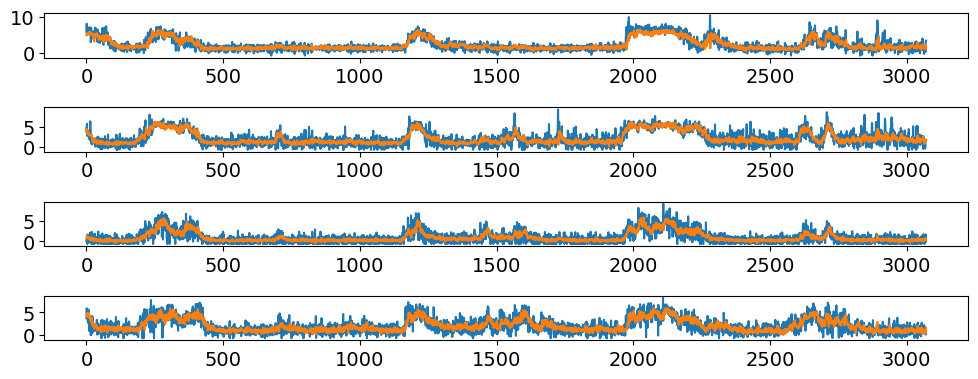

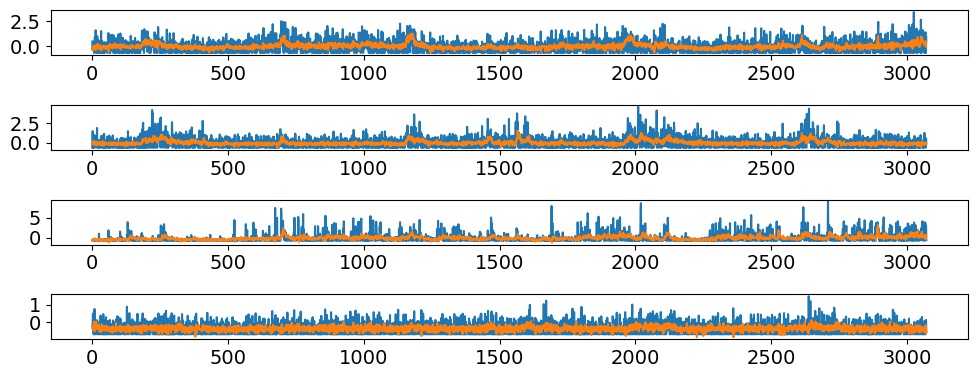

cell finished on hpc_gpu.


In [16]:
np.random.seed(42)
top_idx = np.argsort(corr_per_neuron)[::-1][:4]
random_idx = np.random.choice(np.setdiff1d(np.arange(N), top_idx), 4)
print('top_idx:', top_idx)
print('random_idx:', random_idx)

fig, axes = plt.subplots(4, 1, figsize=(10, 4))
axes = axes.flatten()
for i, idx in enumerate(top_idx):
    ax = axes[i]
    ax.plot(ground_truths_TRAIN[0][:, idx, 0], label='Ground truth')
    ax.plot(predictions_TRAIN[0][:, idx, 0], label='Prediction')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(4, 1, figsize=(10, 4))
axes = axes.flatten()
for i, idx in enumerate(random_idx):
    ax = axes[i]
    ax.plot(ground_truths_TRAIN[0][:, idx, 0], label='Ground truth')
    ax.plot(predictions_TRAIN[0][:, idx, 0], label='Prediction')
plt.tight_layout()
plt.show()

## Model Inference on Validation Data

executing cell on hpc_gpu...
waiting for cell to finish on hpc_gpu...
Predicting DataLoader 0:  18%|█▊        | 4/22 [00:00<00:00, 72.09it/s] 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 22/22 [00:00<00:00, 56.77it/s]
(704, 527, 1) (704, 527, 1)
R^2 0.5531237125396729
correlation 0.74383587
mse: 0.40031987


PREDICT Profiler Report

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                      	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                       	|  -              	|  1708           	|  6.0276         	

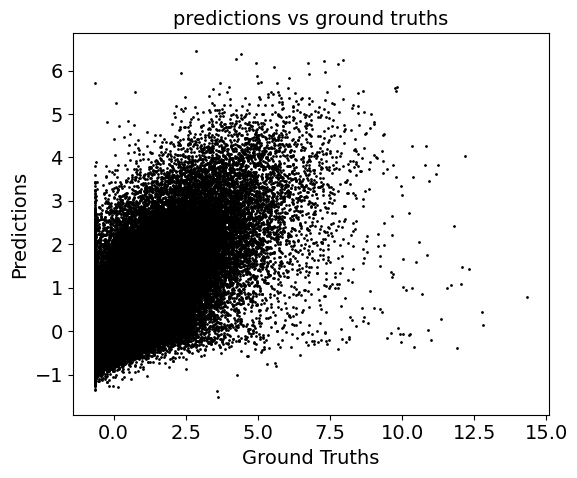

cell finished on hpc_gpu.


In [17]:
val_results = trainer.predict(trained_model, dataloaders=[val_dataloader])

predictions = []
ground_truths = []

index = 0
num_session = len(num_batch_per_session_VAL)
for i in range(num_session):
    predictions.append([])
    ground_truths.append([])

    for j in range(num_batch_per_session_VAL[i]):
        x_hat = val_results[index][0]
        x = val_results[index][1]
        
        predictions[i].append(x_hat)
        ground_truths[i].append(x)
        index += 1
    
    predictions[i] = torch.cat(predictions[i], dim=0).cpu().numpy()  # N * neuron_num * window_size
    ground_truths[i] = torch.cat(ground_truths[i], dim=0).cpu().numpy()  # N * neuron_num * window_size
    print(predictions[i].shape, ground_truths[i].shape)

print('R^2', r2_score(ground_truths[0].reshape(-1), predictions[0].reshape(-1)))
print('correlation', stats.pearsonr(ground_truths[0].reshape(-1), predictions[0].reshape(-1))[0])
print('mse:', np.mean((predictions[0] - ground_truths[0]) ** 2))

plt.figure(figsize=(6, 5))
plt.scatter(ground_truths[0].reshape(-1), predictions[0].reshape(-1), s=1, c='black')
plt.title('predictions vs ground truths')
plt.xlabel('Ground Truths')
plt.ylabel('Predictions')
plt.tight_layout()
plt.show()

# Attention Analysis

## Useful Functions

In [18]:
def multisession_NN_to_KK(
    multisession_NN_list: list,
    cell_type_order: list,
    multisession_cell_type_id_list: list,
):
    KK_result = np.zeros((len(cell_type_order), len(cell_type_order)))
    KK_count = np.zeros((len(cell_type_order), len(cell_type_order)))

    for i in range(len(multisession_NN_list)):
        current_session_NN = multisession_NN_list[i]
        current_session_cell_type_id = multisession_cell_type_id_list[i]

        for j in range(len(current_session_cell_type_id)):
            for k in range(len(current_session_cell_type_id)):
                # Ignore the diagonal elements
                if j == k:
                    continue

                cell_type_j = current_session_cell_type_id[j]
                cell_type_k = current_session_cell_type_id[k]

                KK_result[cell_type_j, cell_type_k] += current_session_NN[j, k]
                KK_count[cell_type_j, cell_type_k] += 1

    KK_count[KK_count == 0] = 1
    return KK_result / KK_count

def experiment_KK_to_eval_KK(
    experiment_KK: np.ndarray,
    experiment_cell_type_order: list,
    eval_cell_type_order: list,
):
    eval_KK = np.zeros((len(eval_cell_type_order), len(eval_cell_type_order)))
    for eval_cell_type_i in eval_cell_type_order:
        if eval_cell_type_i in experiment_cell_type_order:
            experiment_index_i = experiment_cell_type_order.index(eval_cell_type_i)
            eval_index_i = eval_cell_type_order.index(eval_cell_type_i)

            for eval_cell_type_j in eval_cell_type_order:
                if eval_cell_type_j in experiment_cell_type_order:
                    experiment_index_j = experiment_cell_type_order.index(eval_cell_type_j)
                    eval_index_j = eval_cell_type_order.index(eval_cell_type_j)

                    eval_KK[eval_index_i, eval_index_j] = experiment_KK[experiment_index_i, experiment_index_j]

    return eval_KK

def linear_transform(matrix, GT):
    flatten_matrix = matrix.flatten()
    flatten_GT = GT.flatten()

    # linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(flatten_matrix, flatten_GT)
    # postive linear transform
    if slope < 0:
        slope = -slope
        intercept = -intercept

    result = matrix * slope + intercept
    return result

executing cell on hpc_gpu...
waiting for cell to finish on hpc_gpu...
cell finished on hpc_gpu.


## Extract and Visualize Averaged Attention Map

1. Extract attention for each time-window
2. Perform average within each cell type and across all time-windows to get one final cell type-level connectivity

executing cell on hpc_gpu...
waiting for cell to finish on hpc_gpu...


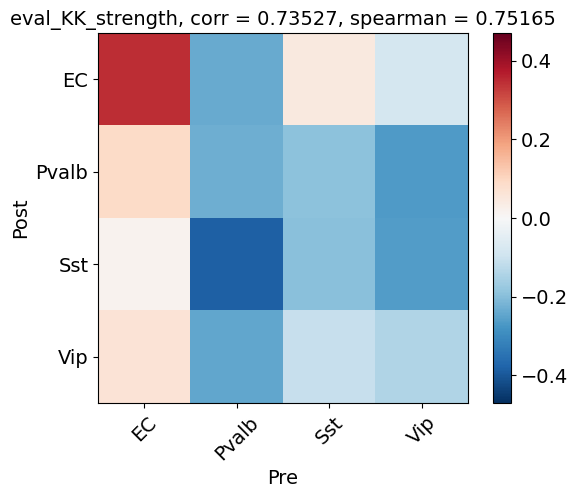

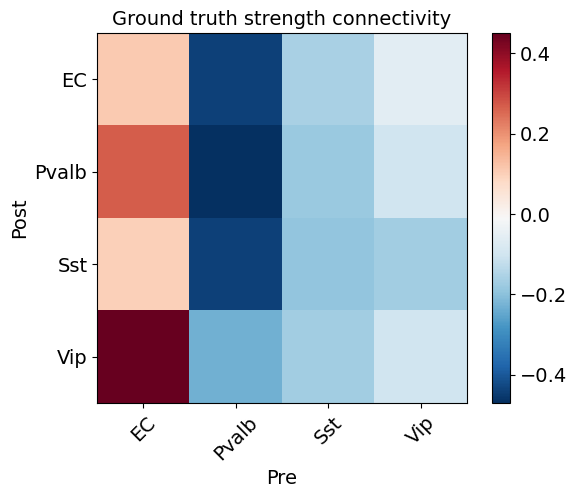

cell finished on hpc_gpu.


In [19]:
attentions = []  # list of (N * neuron_num * neuron_num)
all_sessions_avg_attention_NN = []  # list of (neuron_num * neuron_num)

attentions_by_state = []  # list of (3 * N * neuron_num * neuron_num)
time_index = []  # list of (3 * N)   This is used to track the time step of each sample within a session

index = 0
num_session = len(num_batch_per_session_TRAIN)
for i in range(num_session):
    attentions.append([])
    attentions_by_state.append([[], [], []]) # 3 states for each session
    time_index.append([[], [], []])

    for j in range(num_batch_per_session_TRAIN[i]):
        x_hat = train_results[index][0]
        x = train_results[index][1]
        attention = train_results[index][2]  # B * neuron_num * neuron_num
        state = train_results[index][3].cpu().numpy()   # B * window_size

        attentions[i].append(attention)

        for k in range(state.shape[0]):
            if np.all(state[k] == state[k][0]):
                attentions_by_state[i][state[k][0]].append(attention[k])
                time_index[i][state[k][0]].append(j * batch_size + k)
        
        index += 1

    attentions[i] = torch.cat(attentions[i], dim=0).cpu().numpy()    # N * neuron_num * neuron_num
    # Averaged attention across samples in each session
    all_sessions_avg_attention_NN.append(np.mean(attentions[i], axis=0))   # neuron_num * neuron_num

    attentions_by_state[i][0] = torch.stack(attentions_by_state[i][0], dim=0).cpu().numpy()    # N * neuron_num * neuron_num
    attentions_by_state[i][1] = torch.stack(attentions_by_state[i][1], dim=0).cpu().numpy()    # N * neuron_num * neuron_num
    attentions_by_state[i][2] = torch.stack(attentions_by_state[i][2], dim=0).cpu().numpy()    # N * neuron_num * neuron_num

experiment_KK_strength = multisession_NN_to_KK(
    all_sessions_avg_attention_NN, 
    cell_type_order,
    all_sessions_new_cell_type_id,
)

eval_cell_type_order = ['EC', 'Pvalb', 'Sst', 'Vip']
eval_KK_strength = experiment_KK_to_eval_KK(experiment_KK_strength, cell_type_order, eval_cell_type_order)

corr_strength_KK = stats.pearsonr(GT_strength_connectivity.flatten(), eval_KK_strength.flatten())[0]
spearman_corr_strength_KK = stats.spearmanr(GT_strength_connectivity.flatten(), eval_KK_strength.flatten())[0]

plt.imshow(linear_transform(eval_KK_strength, GT_strength_connectivity), cmap='RdBu_r', interpolation="nearest", vmin=vmin_KK, vmax=vmax_KK)
plt.colorbar()
plt.xlabel("Pre")
plt.ylabel("Post")
plt.title("eval_KK_strength, corr = " + str(corr_strength_KK)[:7] + ", spearman = " + str(spearman_corr_strength_KK)[:7])
plt.xticks(np.arange(len(eval_cell_type_order)), eval_cell_type_order, rotation=45)
plt.yticks(np.arange(len(eval_cell_type_order)), eval_cell_type_order)
plt.show()

plt.imshow(GT_strength_connectivity, cmap='RdBu_r', interpolation="nearest")
plt.colorbar()
plt.xlabel("Pre")
plt.ylabel("Post")
plt.title("Ground truth strength connectivity")
plt.xticks(np.arange(len(eval_cell_type_order)), eval_cell_type_order, rotation=45)
plt.yticks(np.arange(len(eval_cell_type_order)), eval_cell_type_order)
plt.show()

# Behavioral States Analysis

### Classify attentions for all time-windows by behavioral state: 0. Running, 1. Stationary Desynchronized, 2. Stationary Synchronized

In [20]:
print('number of attentions in state 0', attentions_by_state[0][0].shape)
print('number of attentions in state 1', attentions_by_state[0][1].shape)
print('number of attentions in state 2', attentions_by_state[0][2].shape)

# Flatten each attention matrix in a state
state0 = attentions_by_state[0][0].reshape(attentions_by_state[0][0].shape[0], -1)
state1 = attentions_by_state[0][1].reshape(attentions_by_state[0][1].shape[0], -1)
state2 = attentions_by_state[0][2].reshape(attentions_by_state[0][2].shape[0], -1)

# Concatenate all states
state012 = np.concatenate([state0, state1, state2], axis=0)
label = np.concatenate([np.zeros(state0.shape[0]), np.ones(state1.shape[0]), 2 * np.ones(state2.shape[0])])
time_index012 = np.concatenate([time_index[0][0], time_index[0][1], time_index[0][2]])
print('label:', label)
print('time_index012:', time_index012.shape)

executing cell on hpc_gpu...
waiting for cell to finish on hpc_gpu...
number of attentions in state 0 (710, 527, 527)
number of attentions in state 1 (672, 527, 527)
number of attentions in state 2 (415, 527, 527)
label: [0. 0. 0. ... 2. 2. 2.]
time_index012: (1797,)
cell finished on hpc_gpu.


### Perform PCA on attentions for all time-windows, colored by behavioral state labels

executing cell on hpc_gpu...
waiting for cell to finish on hpc_gpu...
(1797, 2)


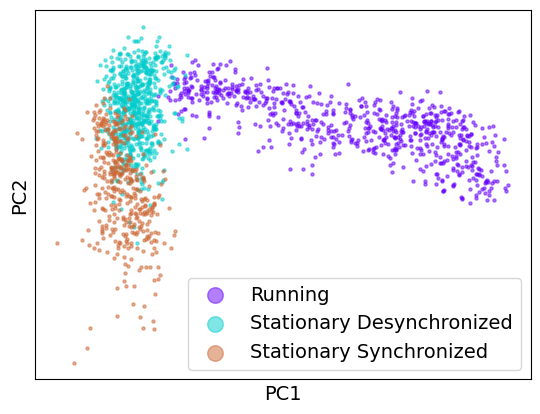

cell finished on hpc_gpu.


In [21]:
# PCA on the attentions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(state012)
print(X_pca.shape)

plt.scatter(X_pca[label == 0, 0], X_pca[label == 0, 1], label='Running', alpha=0.5, s=5, c='#6600FF')
plt.scatter(X_pca[label == 1, 0], X_pca[label == 1, 1], label='Stationary Desynchronized', alpha=0.5, s=5, c='#00CCCC')
plt.scatter(X_pca[label == 2, 0], X_pca[label == 2, 1], label='Stationary Synchronized', alpha=0.5, s=5, c='#CC6633')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xticks([])
plt.yticks([])
plt.legend(markerscale=5)
plt.show()

### Get cell type-level attentions, and then average within the same behavioral state

Note: might takes a while to run

In [22]:
state0 = attentions_by_state[0][0]
state1 = attentions_by_state[0][1]
state2 = attentions_by_state[0][2]
print(state0.shape, state1.shape, state2.shape)

eval_cell_type_order = ['EC', 'Pvalb', 'Sst', 'Vip']

state0_KK = []
for i in range(state0.shape[0]):
    experiment_KK = multisession_NN_to_KK(
        [state0[i]],
        cell_type_order,
        all_sessions_new_cell_type_id,
    )
    eval_KK = experiment_KK_to_eval_KK(experiment_KK, cell_type_order, eval_cell_type_order)
    state0_KK.append(eval_KK)

state1_KK = []
for i in range(state1.shape[0]):
    experiment_KK = multisession_NN_to_KK(
        [state1[i]],
        cell_type_order,
        all_sessions_new_cell_type_id,
    )
    eval_KK = experiment_KK_to_eval_KK(experiment_KK, cell_type_order, eval_cell_type_order)
    state1_KK.append(eval_KK)

state2_KK = []
for i in range(state2.shape[0]):
    experiment_KK = multisession_NN_to_KK(
        [state2[i]],
        cell_type_order,
        all_sessions_new_cell_type_id,
    )
    eval_KK = experiment_KK_to_eval_KK(experiment_KK, cell_type_order, eval_cell_type_order)
    state2_KK.append(eval_KK)

print(len(state0_KK), len(state1_KK), len(state2_KK))

executing cell on hpc_gpu...
waiting for cell to finish on hpc_gpu...
(710, 527, 527) (672, 527, 527) (415, 527, 527)
710 672 415
cell finished on hpc_gpu.


### Visualize the cell type-level attention for each behavioral state

executing cell on hpc_gpu...
waiting for cell to finish on hpc_gpu...
state 0: corr: 0.6823306772778709 spearman: 0.7103923034356484
state 1: corr: 0.7575308961552564 spearman: 0.80913978129911
state 2: corr: 0.7734277893415301 spearman: 0.8400904833160159


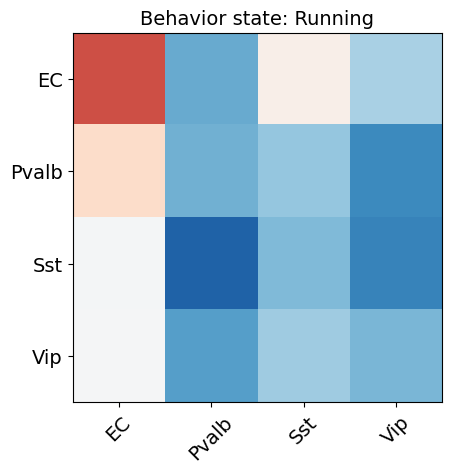

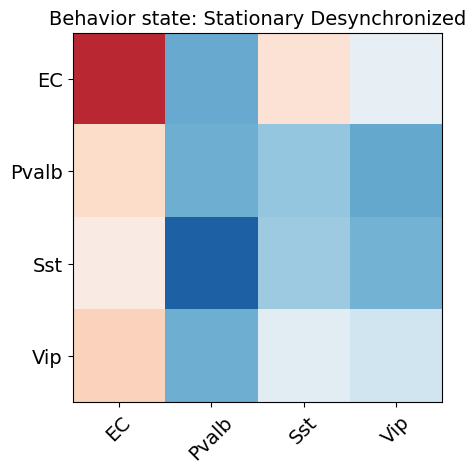

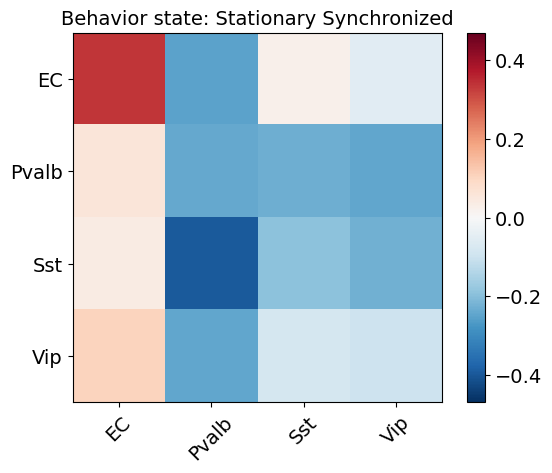

cell finished on hpc_gpu.


In [23]:
# Compute the mean attention map for each state
state0_KK_mean = np.mean(state0_KK, axis=0)
state1_KK_mean = np.mean(state1_KK, axis=0)
state2_KK_mean = np.mean(state2_KK, axis=0)

corr_state0, spearman_state0 = stats.pearsonr(state0_KK_mean.flatten(), GT_strength_connectivity.flatten())[0], stats.spearmanr(state0_KK_mean.flatten(), GT_strength_connectivity.flatten())[0]
corr_state1, spearman_state1 = stats.pearsonr(state1_KK_mean.flatten(), GT_strength_connectivity.flatten())[0], stats.spearmanr(state1_KK_mean.flatten(), GT_strength_connectivity.flatten())[0]
corr_state2, spearman_state2 = stats.pearsonr(state2_KK_mean.flatten(), GT_strength_connectivity.flatten())[0], stats.spearmanr(state2_KK_mean.flatten(), GT_strength_connectivity.flatten())[0]

print('state 0: corr:', corr_state0, 'spearman:', spearman_state0)
print('state 1: corr:', corr_state1, 'spearman:', spearman_state1)
print('state 2: corr:', corr_state2, 'spearman:', spearman_state2)

# linear transformation: apply the SAME linear transformation to all states
flatten_matrix = np.concatenate([state0_KK_mean.flatten(), state1_KK_mean.flatten(), state2_KK_mean.flatten()])
flatten_GT = np.concatenate([GT_strength_connectivity.flatten(), GT_strength_connectivity.flatten(), GT_strength_connectivity.flatten()])

slope, intercept, r_value, p_value, std_err = stats.linregress(flatten_matrix, flatten_GT)
transformed_state0_KK = state0_KK_mean * slope + intercept
transformed_state1_KK = state1_KK_mean * slope + intercept
transformed_state2_KK = state2_KK_mean * slope + intercept

plt.imshow(transformed_state0_KK, cmap='RdBu_r', vmin=vmin_KK, vmax=vmax_KK)
plt.title('Behavior state: Running')
plt.xticks(np.arange(len(eval_cell_type_order)), eval_cell_type_order, rotation=45)
plt.yticks(np.arange(len(eval_cell_type_order)), eval_cell_type_order)
plt.show()
plt.imshow(transformed_state1_KK, cmap='RdBu_r', vmin=vmin_KK, vmax=vmax_KK)
plt.title('Behavior state: Stationary Desynchronized')
plt.xticks(np.arange(len(eval_cell_type_order)), eval_cell_type_order, rotation=45)
plt.yticks(np.arange(len(eval_cell_type_order)), eval_cell_type_order)
plt.show()
plt.imshow(transformed_state2_KK, cmap='RdBu_r', vmin=vmin_KK, vmax=vmax_KK)
plt.title('Behavior state: Stationary Synchronized')
plt.colorbar()
plt.xticks(np.arange(len(eval_cell_type_order)), eval_cell_type_order, rotation=45)
plt.yticks(np.arange(len(eval_cell_type_order)), eval_cell_type_order)
plt.show()

In [24]:
%stop_runtime hpc_gpu
%switch_runtime local

Terminated runtime=hpc_gpu. state={'experimentId': 'CS_Agent_1d3ada95-a396-421f-af92-1ae9f8a29413', 'terminated': True}
Switched to runtime=local.
